In [143]:
%matplotlib notebook
import ipywidgets as widgets
from ipywidgets import IntSlider, interactive
import geopandas as gpd
import psycopg2
import os
import folium



In [144]:
conn = psycopg2.connect(database = "national_tree_map", user = "john", password = "mast3rm4p", host = "35.189.201.90")

# Get some points
Split the  MultiLinestrings using ST_DUMP
Calculate the azimuth to get orientation, divide degrees by mod 180, so that NE = SW, and NW = SE

In [145]:
def getData(x, y, w, z):
    sql = """
      WITH aoi (geom)  AS ( 
         SELECT ST_SetSRID(ST_Expand(ST_MakePoint({}, {}), {}, {}), 27700)
      ),
      streets (usrn, geom) AS (
         SELECT usrn, (ST_Dump(s.geom)).geom 
           FROM streets s, aoi a 
          WHERE ST_Intersects(s.geom, a.geom )
          
     )
     SELECT 
         usrn,  
         ST_Length(s.geom) as length, 
         degrees(ST_Azimuth(ST_PointN(s.geom, 1), ST_PointN(s.geom, ST_Npoints(s.geom))))::integer % 180 AS azimuth, 
         ST_HausdorffDistance(s.geom, ST_MakeLine(
                                        ARRAY[ST_PointN(s.geom, 1), 
                                              ST_PointN(s.geom, ST_Npoints(s.geom))])) AS haus,
         ST_Distance(
                 ST_MakeLine(
                          ARRAY[ST_PointN(s.geom, 1), 
                               ST_PointN(s.geom, ST_Npoints(s.geom))]), 
                       ST_ClosestPoint(s.geom, 
                               ST_LineInterpolatePoint(ST_MakeLine(
                                        ARRAY[ST_PointN(s.geom, 1), 
                                              ST_PointN(s.geom, ST_Npoints(s.geom))]), 0.5)))
                /ST_Length(s.geom) * 100 as distance,
         s.geom as geom,
         ST_X(ST_Transform(ST_LineInterpolatePoint(s.geom, 0.5), 4326)) as x,
         ST_Y(ST_Transform(ST_LineInterpolatePoint(s.geom, 0.5), 4326)) as y
      FROM streets s , aoi 
      WHERE degrees(ST_Azimuth(ST_PointN(s.geom, 1), ST_PointN(s.geom, ST_Npoints(s.geom))))::integer % 180  > 30 
        AND degrees(ST_Azimuth(ST_PointN(s.geom, 1), ST_PointN(s.geom, ST_Npoints(s.geom))))::integer % 180  < 60
        AND ST_Intersects(s.geom, aoi.geom);
    """.format(x, y, w, z)
    
    df = gpd.GeoDataFrame.from_postgis(sql, conn, geom_col = 'geom')
    df.plot(column='azimuth', linewidth = 4, cmap='spectral', figsize = (5, 5))
    return df
#df = getData(525000, 193000)


In [146]:
x = IntSlider(value = 525000, min = 0, max = 600000, description='x')
y = IntSlider(value = 185000, min = 0, max = 1300000, description='y')
w = IntSlider(value = 5000, min = 500, max = 50000, description='w')
z = IntSlider(value = 5000, min = 500, max = 50000, description='z')

#def getData(x, y, w, z):
#    df.plot(column='azimuth', linewidth = 4, cmap='spectral', figsize = (5, 5))
    
out = widgets.interactive_output(getData, {'x': x, 'y': y, 'w': w, 'z': z})
widgets.HBox([widgets.VBox([x, y, w, z]), out])


#p = widgets.interactive(getData, x , y, w, z)
#p





A Jupyter Widget

<IPython.core.display.Javascript object>


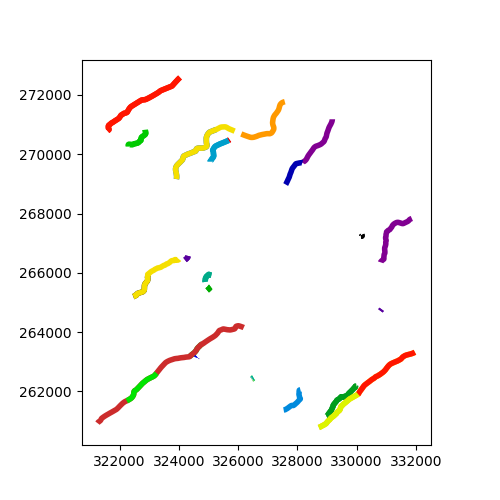

,usrn,length,azimuth,haus,distance,geom,x,y
0,85307414,2139.506734,35,431.190412,12.911064,"LINESTRING (330806.835 266353.548, 330808 2663...",-3.013153,52.299976
1,85307436,23.265517,38,2.326049,8.648863,"LINESTRING (324604.402 263135.489, 324606.096 ...",-3.106023,52.261288
2,85315662,2303.834690,53,579.467563,10.387686,"LINESTRING (326105.128 270684.558, 326174.728 ...",-3.070090,52.330352
3,85315664,2506.645560,39,291.263889,3.674576,"LINESTRING (325256 270834, 325055.328 270753.7...",-3.108991,52.323668
4,85315725,607.514769,45,17.940606,1.597716,"LINESTRING (324787.304 263595.469, 324762.756 ...",-3.106486,52.263368


In [160]:
df = getData(x.value, y.value, w.value, z.value)
df.head()

In [148]:
df.describe()

,usrn,length,azimuth,haus,distance,x,y
count,2.251000e+03,2251.000000,2251.000000,2251.000000,2251.000000,2251.000000,2251.000000
mean,1.755383e+07,140.509418,47.078632,11.590247,5.595522,-0.187561,51.546635
std,5.178734e+06,203.950726,8.171089,28.285928,6.542841,0.042308,0.025472
min,8.400008e+06,1.942264,31.000000,0.000000,0.000000,-0.273554,51.504036
25%,2.000166e+07,26.351029,40.000000,0.407475,0.154648,-0.220670,51.524351
50%,2.020114e+07,72.360719,48.000000,2.543302,2.326011,-0.183190,51.544805
75%,2.040094e+07,173.522148,54.000000,8.290720,10.062544,-0.146218,51.567476
max,2.170133e+07,2239.944470,59.000000,329.646359,29.624300,-0.124410,51.596103


In [149]:
df.corr()

,usrn,length,azimuth,haus,distance,x,y
usrn,1.000000,0.060054,-0.147161,0.089111,0.083582,-0.265855,0.573240
length,0.060054,1.000000,-0.018694,0.715981,-0.036681,-0.073377,0.072580
azimuth,-0.147161,-0.018694,1.000000,-0.064571,-0.116456,0.028841,-0.096073
haus,0.089111,0.715981,-0.064571,1.000000,0.294115,-0.100855,0.095264
distance,0.083582,-0.036681,-0.116456,0.294115,1.000000,-0.078760,0.041402
x,-0.265855,-0.073377,0.028841,-0.100855,-0.078760,1.000000,-0.233864
y,0.573240,0.072580,-0.096073,0.095264,0.041402,-0.233864,1.000000


In [150]:
df[df['distance'] > 0].count()['distance']

1993

In [151]:
#df_haus = df[(df.haus > 2) & (df.length > 250)]

In [152]:
#df_haus.plot(column='haus', linewidth = 4, cmap='seismic', figsize = (10, 10))

In [153]:
#df_haus = df[(df.azimuth > 0) & (df.azimuth < 90) & (df.length > 200)]
#df_haus.plot(column='haus', linewidth = 4, cmap='seismic', figsize = (8, 8))

In [154]:
#import json
#df_json = json.loads(df.to_json())

In [161]:
#import pyproj
#wgs84=pyproj.Proj("+init=EPSG:4326")
#osgb36=pyproj.Proj("+init=EPSG:27700")

#for feat in df_json['features']:
#    for coords in feat['geometry']['coordinates']:
#        x, y = coords[0], coords[1]
#        coords[1], coords[0] = pyproj.transform(osgb36, wgs84, x, y)


df.crs = {'init': 'epsg:27700'}
gdf_wgs84 = df.to_crs({'init': 'epsg:4326'})
#gdf_wgs84.head()
gdf_wgs84.head()

,usrn,length,azimuth,haus,distance,geom,x,y
0,85307414,2139.506734,35,431.190412,12.911064,LINESTRING (-3.015898894048869 52.290939044843...,-3.013153,52.299976
1,85307436,23.265517,38,2.326049,8.648863,LINESTRING (-3.106097834329979 52.261195894686...,-3.106023,52.261288
2,85315662,2303.834690,53,579.467563,10.387686,LINESTRING (-3.08577248950832 52.3292556223089...,-3.070090,52.330352
3,85315664,2506.645560,39,291.263889,3.674576,LINESTRING (-3.098263587660588 52.330483703663...,-3.108991,52.323668
4,85315725,607.514769,45,17.940606,1.597716,LINESTRING (-3.103521208273884 52.265355557574...,-3.106486,52.263368


In [162]:
roads = folium.Map([51.584, -0.1624], zoom_start  = 12)
style_function = lambda x: {'color': 'red' if x['properties']['distance'] > 3.3 else 'green' }
highlight_function = lambda x: {'color': 'black'}
folium.GeoJson(gdf_wgs84, style_function = style_function, highlight_function = highlight_function).add_to(roads)

#sf = lambda x: {'color': 'red' if x['length'] < 60 else 'green'}
#gj.add_child(folium.Popup('outline Popup on GeoJSON'))
#gj.add_to(roads)



roads.fit_bounds(roads.get_bounds())
roads



In [163]:
from folium.plugins import MarkerCluster

marker_cluster = MarkerCluster().add_to(roads)

for index, row in gdf_wgs84.iterrows():
    folium.Marker([row['y'], row['x']], popup = "USRN:{}<br> Hausdorff:{:.2f}".format(row['usrn'], row['haus'])).add_to(marker_cluster)
    
roads.fit_bounds(roads.get_bounds())
roads